## Recommending Chess Openings from Lichess Dataset

Exploring, plotting and analysing a dataset of chess games from the Lichess site, and creating a recommendation engine using the dataset.

### Exploring the dataset

In [135]:
import pandas as pd
chess_games = pd.read_csv("data/games.csv")
chess_games.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [136]:
chess_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


The dataset includes 20058 unique chess games from Lichess, detailing information about black and white, their ratings, the opening name and ECO rating, the sequence of opening moves, and other crucial information.

Before creating our reccommendation engine, we must first investigate whether we have a large enough sample size, whether the data is large/strong enough to support this task, and augment the dataset with extra columns.

In [137]:
#Adding opening type and moves to the dataset, 

def opening_type(opening_name):
    return opening_name.split(":")[0].split("|")[0].split("#")[0].strip()

def opening_moves(row):
    return row["moves"].split(" ")[:row['opening_ply']]

# Modify the dataframe to include the opening type and moves
chess_games = chess_games.assign(
    opening_type = chess_games["opening_name"].map(opening_type),
    opening_moves = chess_games.apply(opening_moves, axis = 1)
)

We do not gain valuable information on opening preferences from players who have only 1 game played in the dataset. I will instead query the dataset for players who have at least 2 games played.

There are 4466 players have played more than 2 games


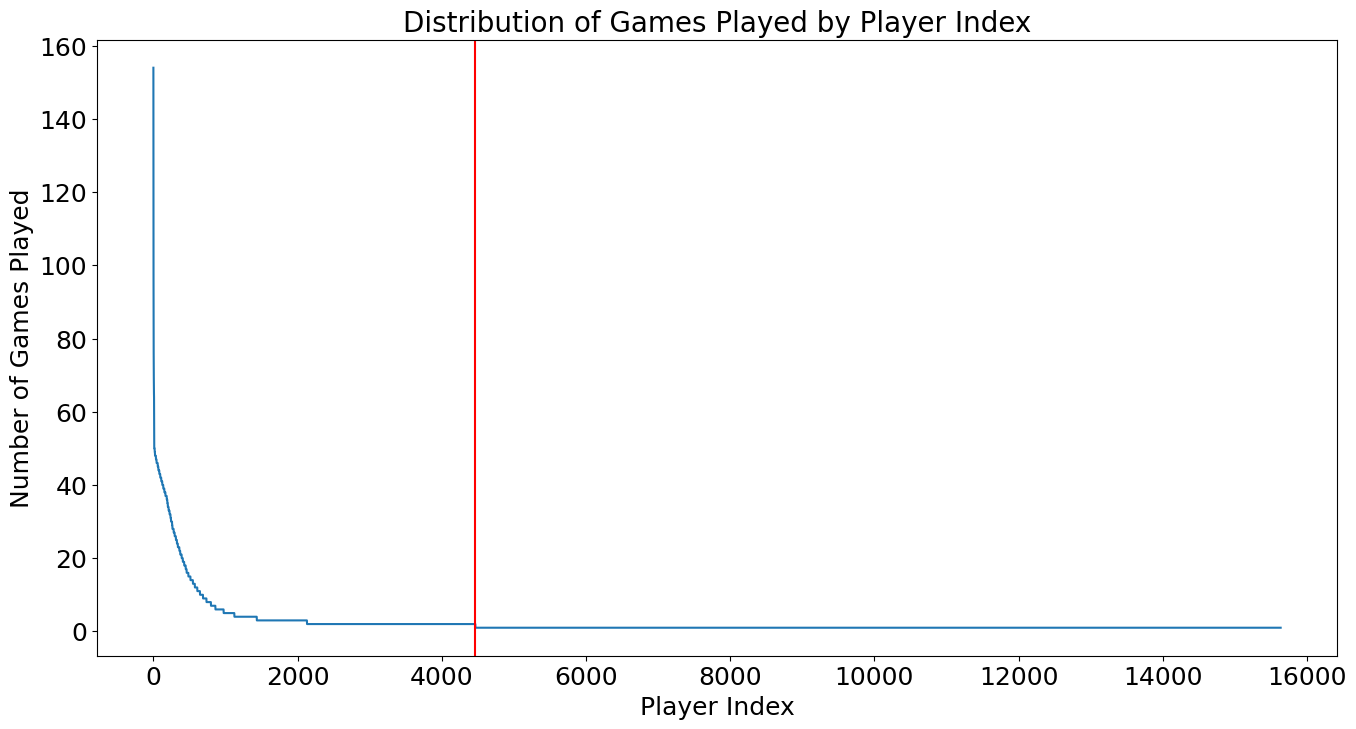

In [138]:
import matplotlib.pyplot as plt

# Plot the distribution of games played by player index
games_played = pd.concat([chess_games["white_id"], chess_games["black_id"]]).value_counts()
ax = games_played.reset_index(drop = True).plot.line(figsize = (16, 8), fontsize = 18)
ax.set_xlabel("Player Index", fontsize = 18)
ax.set_ylabel("Number of Games Played", fontsize = 18)
plt.title("Distribution of Games Played by Player Index", fontsize = 20)

# Find the number of players who have played more than 2 games
line_ge_2 = len(games_played[games_played >= 2])
print(f"There are {str(line_ge_2)} players have played more than 2 games")

# Plot line to show the number of players who have played more than 2 games
plt.axvline(line_ge_2, color = "red")

plt.show()


Let's take a look at descriptive statistics regarding the players who have played at least 2 games in our dataset.

In [139]:
print(games_played[games_played >= 2].describe())
print(f"{games_played[games_played >- 2].sum()} games played")

count    4466.000000
mean        6.481639
std        10.276480
min         2.000000
25%         2.000000
50%         2.000000
75%         5.000000
max       154.000000
Name: count, dtype: float64
40116 games played


#### Exploring variance of players' opening strategies

Our reccomendations from the chess engine are only as interesting as the variance in the opening strategies. If players tend to use the same opening moves repeatedly, we will see the same standard strategies being reccomended.

I wanted to investigate the difference in opening choices between players who commonly play the **Italian Game** (a classical, strategic opening that typically evolves into open positions) and the **Scandinavian Defense** (a more tactical position, with an assymetrical position and quick simplification).

In [140]:
# Create a dataframe of opening_types and times_used for each player
opening_used = (
    pd.concat([
        chess_games.groupby("white_id")['opening_type'].value_counts().reset_index(name="times_used").assign(player_id=lambda df: df["white_id"]),
        chess_games.groupby("black_id")['opening_type'].value_counts().reset_index(name="times_used").assign(player_id=lambda df: df["black_id"])
    ])
    .drop(columns=["white_id", "black_id"], errors="ignore")  # Remove these columns if they exist
    .groupby(["player_id", "opening_type"])
    .sum()
    .reset_index()
)

In [141]:
opening_used.head(15)

,player_id,opening_type,times_used
0,--jim--,Scandinavian Defense,1
1,-0olo0-,French Defense,1
2,-l-_jedi_knight_-l-,Guatemala Defense,1
3,-l-_jedi_knight_-l-,Hungarian Opening,3
4,-l-_jedi_knight_-l-,King's Gambit Accepted,1
5,-l-_jedi_knight_-l-,Owen Defense,2
6,-l-_jedi_knight_-l-,Pirc Defense,1
7,-l-_jedi_knight_-l-,Scandinavian Defense,4
8,-mati-,Barnes Defense,1
9,-pavel-,Scandinavian Defense,1


In [142]:
# Function to get most likely openings played for a given opening
def get_top_openings(target_opening):
    return (
        opening_used
            .reset_index()
            .groupby("player_id")
            .filter(lambda df: df.opening_type.isin([target_opening]).any())
            .query(f'opening_type != "{target_opening}"')
            .groupby("opening_type")
            .times_used
            .sum()
            .sort_values(ascending = False)
            .to_frame()
            .pipe(lambda df: df.assign(times_used = df.times_used / df.times_used.sum()))
            .squeeze()
    )

In [143]:
get_top_openings("Italian Game").head(10)

opening_type
Sicilian Defense        0.140968
French Defense          0.069355
Queen's Pawn Game       0.063441
Ruy Lopez               0.062688
King's Pawn Game        0.052688
Philidor Defense        0.042903
Scandinavian Defense    0.035699
Scotch Game             0.032581
Four Knights Game       0.030538
Caro-Kann Defense       0.028817
Name: times_used, dtype: float64

In [144]:
get_top_openings("Scandinavian Defense").head(10)

opening_type
Sicilian Defense     0.140731
French Defense       0.077465
King's Pawn Game     0.062472
Italian Game         0.059064
Queen's Pawn Game    0.058610
Ruy Lopez            0.048160
Philidor Defense     0.046343
English Opening      0.031009
Scotch Game          0.030100
Caro-Kann Defense    0.029305
Name: times_used, dtype: float64

Players who play the Italian Game and Scandanavian Defense opt for very similar openings in both cases. Both players generally opt for the Sicilian and French Defense with black, and also choose to play the Queen's Pawn Game (1.d4) and the Ruy Lopez with white (1.e4 e5 2.nf3 nc6 3.bb5). However, the Italian Game player is much more likely to play the Ruy Lopez, by about 40%, possibly due to the identical opening moves of both openings up until nf3 nc6. 

Overall, there is promising evidence that recommendations by our chess engine will be useful due to natural variance in openings between players.

### Chess Recommendation Engine

We will use **collaborative filtering**, a technique that can filter out items that a user might like on the basis of reactions by similar users. 

Users will be measured for similarity between their opening ratings based on a similarity metric. Unfortunately, our current dataset has no explicit rating for the openings; user do not rate their chess openings on a ranking system. However, we can create ratings by analysing the frequency of games played by each player. If a user has played `N` games, we will assign a rating 5 stars if a player has played it at least `N / 4` times, 4 stars for `N / 8 times`, 3 stars for `N / 16` times, and 2 stars otherwise.

In [145]:
# Calculate N for each player
player_game_counts = opening_used.groupby('player_id')['times_used'].sum().reset_index()
player_game_counts.rename(columns={'times_used': 'total_games'}, inplace=True)

# Merge with the original DataFrame
opening_used = pd.merge(opening_used, player_game_counts, on='player_id')

# Assign star ratings based on the new rules
def assign_star_rating(row):
    N = row['total_games']
    times_used = row['times_used']
    if times_used > N / 4:
        return 5
    elif times_used > N / 8:
        return 4
    elif times_used > N / 16:
        return 3
    else:
        return 2

opening_used['star_rating'] = opening_used.apply(assign_star_rating, axis=1)

# Create 2D table
rating_table = opening_used.pivot(index='player_id', columns='opening_type', values='star_rating')

print(rating_table)


opening_type         Alekhine Defense  Amar Opening  Amazon Attack   
player_id                                                            
--jim--                           NaN           NaN            NaN  \
-0olo0-                           NaN           NaN            NaN   
-l-_jedi_knight_-l-               NaN           NaN            NaN   
-mati-                            NaN           NaN            NaN   
-pavel-                           NaN           NaN            NaN   
...                               ...           ...            ...   
zzeljko                           NaN           NaN            NaN   
zzhdan                            NaN           NaN            NaN   
zztopillo                         NaN           NaN            NaN   
zzzbbb                            NaN           NaN            NaN   
zzzimon                           NaN           NaN            NaN   

opening_type         Anderssen Opening  Australian Defense  Barnes Defense   
player_id  

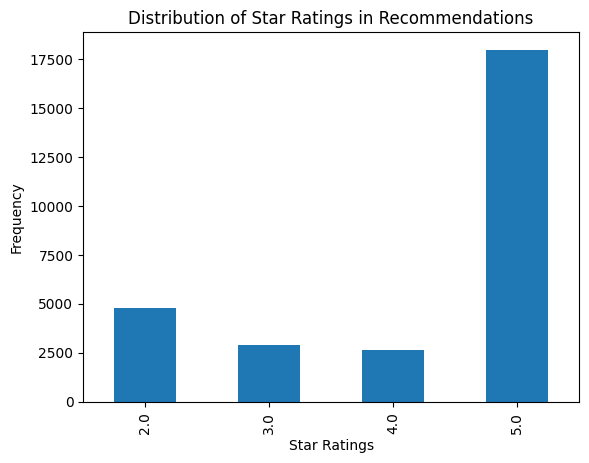

In [152]:
ax = pd.Series(rating_table.values.flatten()).value_counts().sort_index().plot.bar()

ax.set_xlabel('Star Ratings')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Star Ratings in Recommendations')

plt.show()

We can see that there is a distribution of mostly 5 star rated openings, which is typical of natural ratings on a scale of 5 stars.

### Cosine Similarity Metric

We will use the Cosine Similarity Metric to measure how similar two users are based on their openings. The concept behind cosine similarity is as follows: each of the possible openings is a plane in N-dimensional space. The strength of the opening's rating contributes to the strength of the vector in our space, and at the end we take the cosine of the angle between 2 of these vectors, and get a metric between 0 and 1.



In [148]:
from sklearn.metrics.pairwise import pairwise_distances
# user_similarity = pairwise_distances(train.fillna(0), metric='cosine')
item_similarity = pairwise_distances(rating_table.T.fillna(0), metric='cosine')

In [154]:
item_similarity.shape

(143, 143)

This gives us a similarity matrix of how similar each of our 143 opening strategies is to every other strategy in the set. We can get our recommendations from taking the dot product between the matrix and the user ratings matrix.

In [155]:
correction = np.array([np.abs(item_similarity).sum(axis = 1)])
item_predictions = rating_table.fillna(0).dot(item_similarity).apply(
    lambda row: row / np.array([item_similarity.sum(axis = 1)]).flatten(), axis = 'columns'
)

In [156]:
item_predictions.head(10)

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
player_id,,,,,,,,,,,,,,,,,,,,,
--jim--,0.034188,0.035277,0.034330,0.035067,0.035176,0.035181,0.034963,0.035222,0.035360,0.035315,...,0.034973,0.035050,0.034704,0.034072,0.033940,0.035127,0.035004,0.034545,0.035009,0.033747
-0olo0-,0.034130,0.035120,0.034717,0.035199,0.035229,0.034997,0.035152,0.034655,0.035037,0.035239,...,0.034867,0.034190,0.034337,0.032253,0.034533,0.034973,0.035258,0.034967,0.035148,0.034278
-l-_jedi_knight_-l-,0.153264,0.155313,0.153106,0.154270,0.154615,0.154377,0.154441,0.155236,0.154802,0.155193,...,0.154830,0.154374,0.154241,0.151567,0.153107,0.154704,0.154227,0.154204,0.154891,0.151958
-mati-,0.035654,0.035448,0.035367,0.035459,0.034186,0.000000,0.035296,0.035345,0.035360,0.035315,...,0.035251,0.035238,0.035156,0.034819,0.035719,0.035260,0.035121,0.035539,0.035401,0.034495
-pavel-,0.034188,0.035277,0.034330,0.035067,0.035176,0.035181,0.034963,0.035222,0.035360,0.035315,...,0.034973,0.035050,0.034704,0.034072,0.033940,0.035127,0.035004,0.034545,0.035009,0.033747
1063314,0.068623,0.070314,0.069773,0.069630,0.069405,0.070179,0.070456,0.070397,0.069663,0.070523,...,0.069542,0.070331,0.069328,0.068363,0.068585,0.069841,0.070422,0.069804,0.069400,0.067634
1111112222,0.102375,0.105349,0.105078,0.104153,0.105482,0.105060,0.104296,0.104935,0.104036,0.105407,...,0.104323,0.105172,0.104031,0.102023,0.103179,0.105468,0.104570,0.105672,0.104587,0.102257
1240100948,0.179944,0.182604,0.182319,0.181491,0.182092,0.182755,0.182181,0.182386,0.181983,0.182645,...,0.180781,0.182876,0.181010,0.178867,0.180424,0.182905,0.182656,0.182113,0.181461,0.179437
12ss34,0.035012,0.035354,0.035240,0.034995,0.035053,0.035281,0.035296,0.034886,0.034812,0.035315,...,0.034943,0.035238,0.034851,0.034743,0.034725,0.035260,0.035359,0.035408,0.035061,0.035149


In [157]:
recommended_numbers = item_predictions.apply(
    lambda row: np.argmax(row.values), axis = 'columns'
)

In [158]:
recommended_numbers.head(10)

player_id
--jim--                 25
-0olo0-                129
-l-_jedi_knight_-l-     56
-mati-                 124
-pavel-                 25
1063314                 54
1111112222             122
1240100948              50
12ss34                 132
1714-2014              129
dtype: int64

In [159]:
opening_names = pd.Series(rating_table.columns)
recommended_openings = recommended_numbers.map(opening_names)

In [161]:
recommended_openings.head(10)

player_id
--jim--                Center Game Accepted
-0olo0-                              System
-l-_jedi_knight_-l-    Hippopotamus Defense
-mati-                     Sicilian Defense
-pavel-                Center Game Accepted
1063314                   Guatemala Defense
1111112222                      Semi-Bononi
1240100948                   Global Opening
12ss34                         Torre Attack
1714-2014                            System
dtype: object

This gives each player their recommended opening! These openings are based on what openings the user plays, and attemps to recommend systems that are largely similar in strategy, positional complexity, etc. This is done using cosine similarity.

### Recommended Openings

What openings are recommended the most?

Text(0, 0.5, 'Frequency')

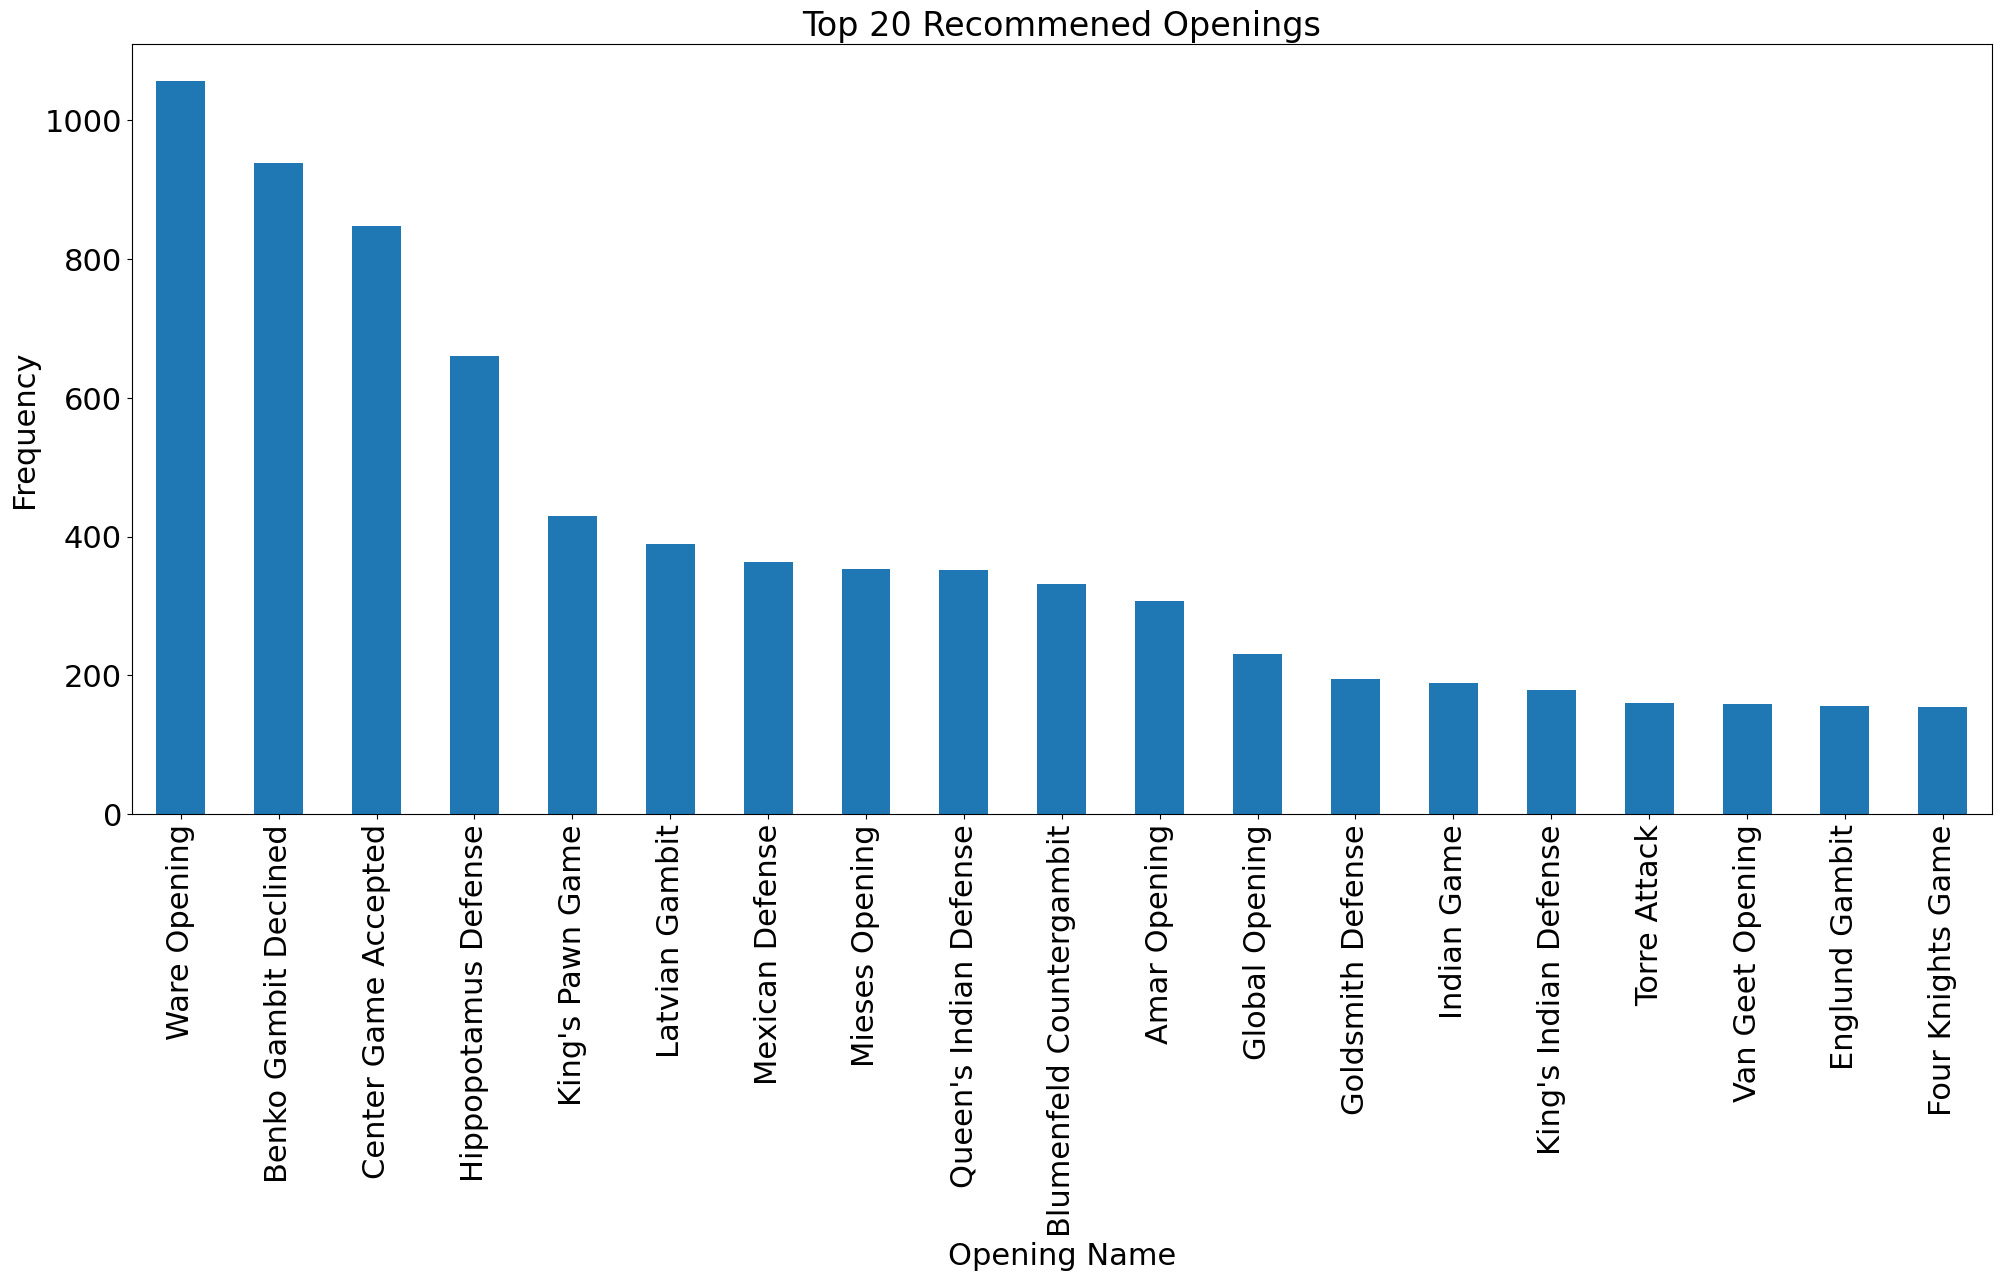

In [165]:
ax = recommended_openings.value_counts().head(20).iloc[1:].plot.bar(figsize = (24, 10), fontsize = 22)

ax.set_title('Top 20 Recommened Openings', fontsize = 24)
ax.set_xlabel('Opening Name', fontsize = 22)
ax.set_ylabel('Frequency', fontsize = 22)

What openings are recommended the least?

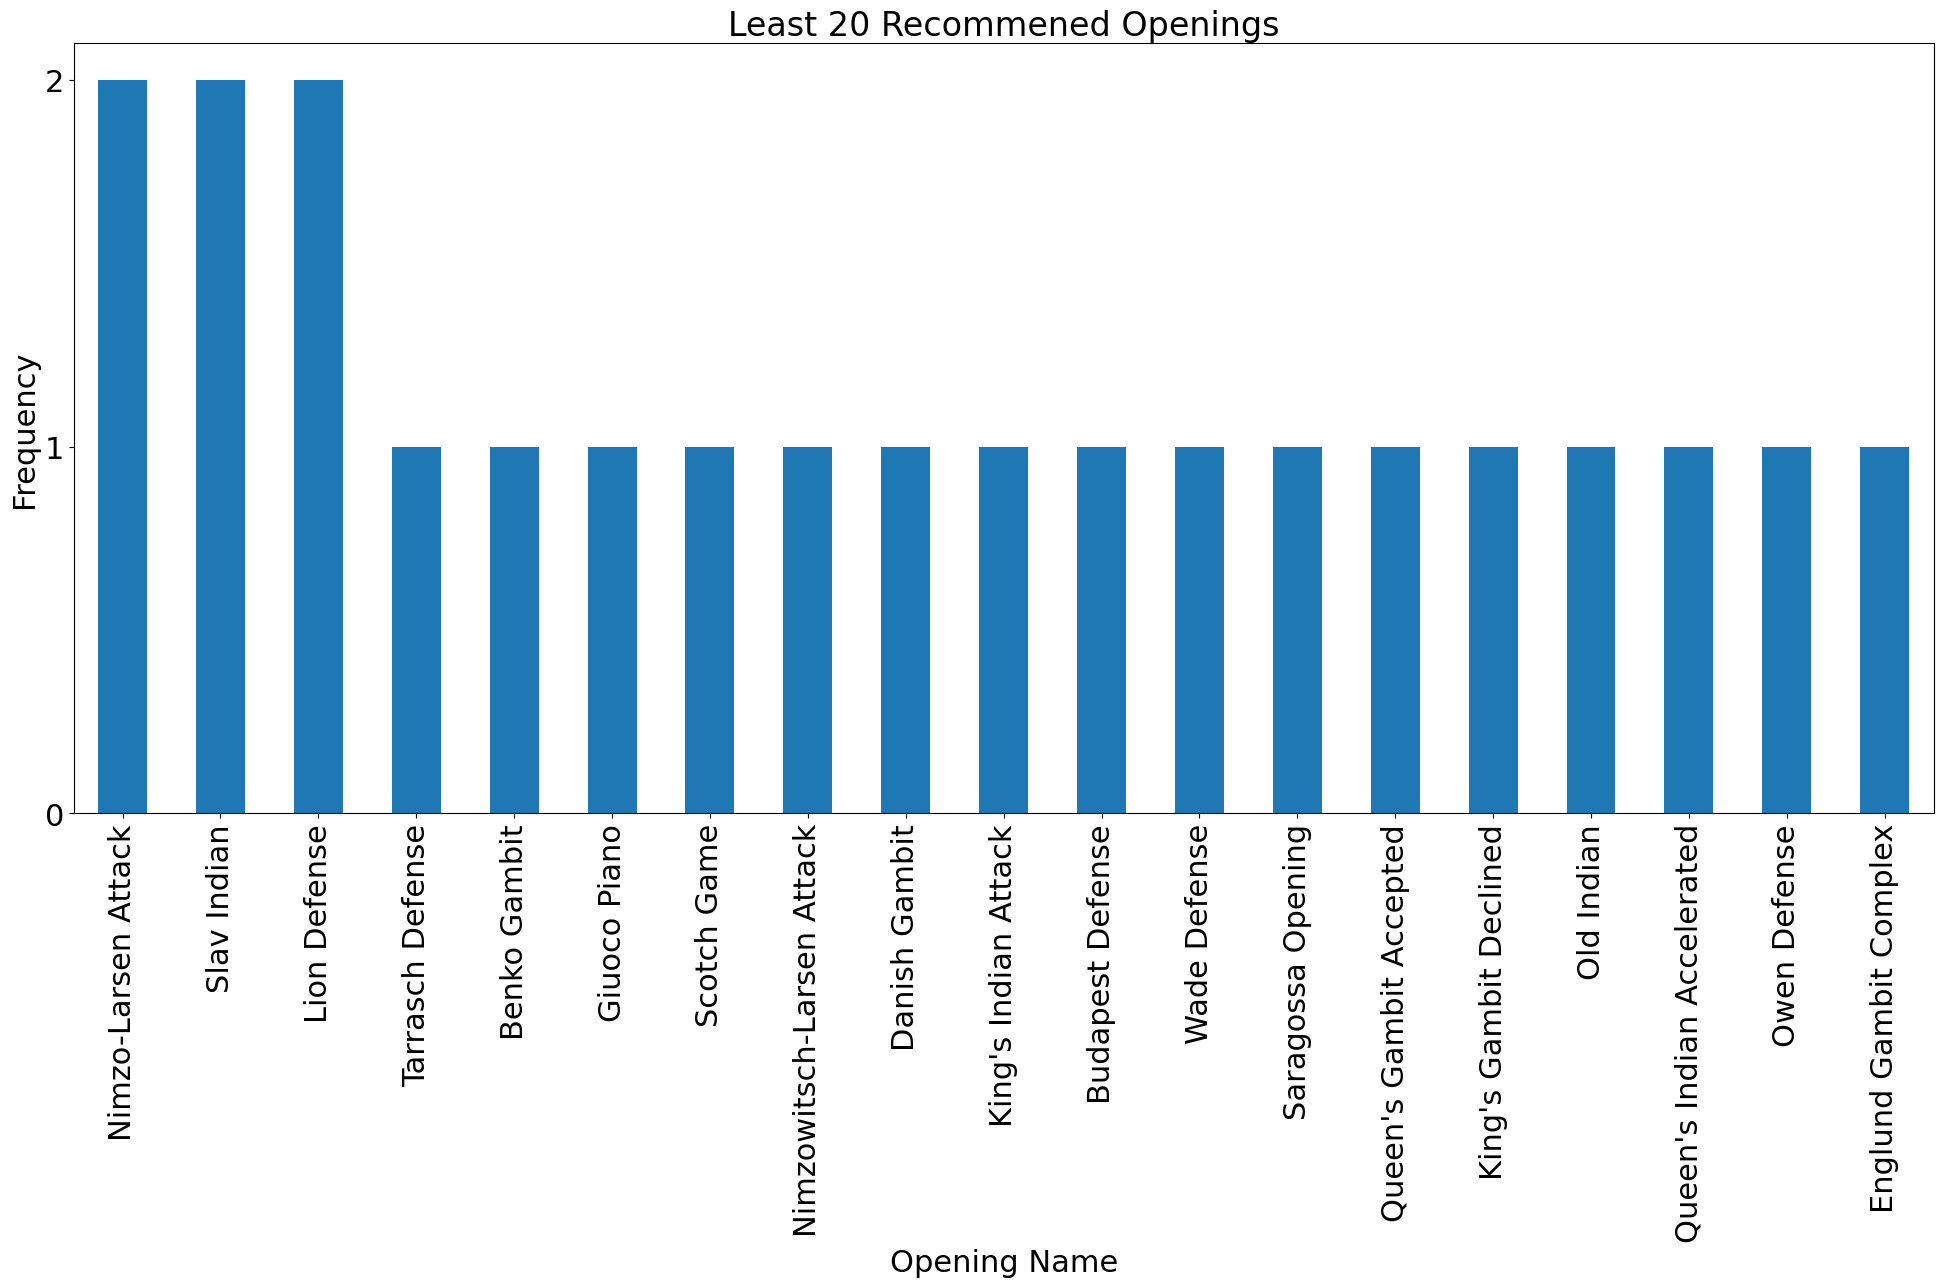

In [168]:
ax = recommended_openings.value_counts().tail(20).iloc[1:].plot.bar(figsize = (24, 10), fontsize = 22)

ax.set_title('Least 20 Recommened Openings', fontsize = 24)
ax.set_xlabel('Opening Name', fontsize = 22)
ax.set_ylabel('Frequency', fontsize = 22)
ax.set_yticks([0, 1, 2])

## Conclusion

I built this recommendation engine as a way to work on some fundamental data processing and analysis with Python, as well as data visualization with Pandas and Matplotlib.

I built a sjmple collaborative filtering recommendation engine based on ratings from opening frequencies. While the engine is not perfect, it did help me learn about key concepts to determine likeness between two items, such as the cosine similarity metric, collaborative filtering, etc. 